# Импорт библиотек

In [2]:
# import vegas
import math
import numpy as np
from scipy.optimize import root, show_options
import matplotlib.pyplot as plt

# Функции

Проверяем работу библиотеки на простом интеграле

In [26]:
import vegas
import numpy as np
import math
from scipy.special import erf

# Аналитическое значение
analytical_value = (math.sqrt(math.pi) * erf(1))**2
print(f"✅ Аналитическое значение: {analytical_value:.6f}")

# Функция для интегрирования (просто!)
def integrand(x):
    """x[0] и x[1] уже в [-1, 1] благодаря настройкам интегратора"""
    return np.exp(-x[0]**2 - x[1]**2)

# Создаем интегратор с НУЖНЫМИ границами!
integrator = vegas.Integrator([[-1, 1], [-1, 1]])  # Вот здесь указываем границы!


# Адаптация и расчет
print("\n🔄 Считаем интеграл с прямыми границами...")
result = integrator(integrand, nitn=10, neval=2000)

# Результаты
numerical_value = result.mean
error = result.sdev
relative_error = abs(numerical_value - analytical_value) / analytical_value

print(f"\n📊 Результаты:")
print(f"   Численное значение: {numerical_value:.6f}")
print(f"   Ошибка: ±{error:.6f}")
print(f"   Относительная ошибка: {relative_error:.2%}")
print(f"   χ²/dof: {result.chi2/9:.2f}")

# Проверка: если относительная ошибка > 1%, предупреждаем
if relative_error > 0.01:
    print("⚠️  Предупреждение: большая ошибка! Увеличьте neval.")
else:
    print("✅  Результат точный!")

✅ Аналитическое значение: 2.230985

🔄 Считаем интеграл с прямыми границами...

📊 Результаты:
   Численное значение: 2.230706
   Ошибка: ±0.000399
   Относительная ошибка: 0.01%
   χ²/dof: 0.87
✅  Результат точный!


## Расчёт без семплирования (линейная по параметрам модель + независимые ошибки)

### Для расчёта матожидания при линейности в экспоненте

In [27]:
def compute_expectation_stable(k, z_min, z_max):
    """
    Численно устойчивая версия вычисления мат.ожидания
    Работает для больших |k| (до 1e6)
    """
    # Случай k ≈ 0
    if abs(k) < 1e-10:
        return (z_min + z_max) / 2
    
    # Защита от переполнения для больших |k|
    if abs(k) > 100:
        # Асимптотическое приближение для больших |k|
        if k > 0:
            # Плотность смещена к z_min
            return z_min + 1/k
        else:
            # Плотность смещена к z_max
            return z_max + 1/k
    
    # Стандартный расчет для умеренных |k|
    try:
        exp_min = np.exp(-k * z_min)
        exp_max = np.exp(-k * z_max)
        
        numerator = exp_min * (k * z_min + 1) - exp_max * (k * z_max + 1)
        denominator = k * (exp_min - exp_max)
        
        if abs(denominator) < 1e-15:
            return (z_min + z_max) / 2
        
        return numerator / denominator
    except OverflowError:
        # Резервный вариант при переполнении
        if k > 0:
            return z_min + 1/k
        else:
            return z_max + 1/k

#### Более оптимальная

In [ ]:
a = np.array([np.exp(750), 1])
a == float('inf')

C:\Users\M A C H R E A T O R\AppData\Local\Temp\ipykernel_17636\4217497900.py:1: RuntimeWarning: overflow encountered in exp
  a = np.array([np.exp(750), 1])


array([ True, False])

In [15]:
a = np.array([np.exp(-750), 1])
a == 0

array([ True, False])

In [ ]:
def compute_expectations_vectorized_stable(k_vector, z_min, z_max):
    
    # 1. Начальная инициализация
    k_vector = np.asarray(k_vector, dtype=float)
    n = len(k_vector)
    E_z = np.zeros(n, dtype=float)

    nonzero_mask = ~zero_mask
    if not np.any(nonzero_mask):
        return E_z
    
    k_nonzero = k_vector[nonzero_mask]
    
    # 4. Вычисляем экспоненты
    exp_min = np.exp(-k_nonzero * z_min)
    exp_max = np.exp(-k_nonzero * z_max)
    
    # 5. Маски для различных комбинаций экспонент

    # Маски для бесконечностей
    inf_mask_min = np.isinf(exp_min)
    inf_mask_max = np.isinf(exp_max)
    
    # Маски для нулей (очень маленьких значений)
    zero_mask_min = exp_min < 1e-300
    zero_mask_max = exp_max < 1e-300

    # Комбинационные маски
    both_inf_mask = inf_mask_min & inf_mask_max
    both_zero_mask = zero_mask_min & zero_mask_max
    max_inf_zero_min_mask = inf_mask_max & zero_mask_min
    min_inf_zero_max_mask = inf_mask_min & zero_mask_max

    # 6. Обработка каждого случая
    # Случай 1: обе экспоненты = ∞
    if np.any(both_inf_mask):
        k_case = k_nonzero[both_inf_mask]
        E_z[nonzero_mask][both_inf_mask] = z_max + 1/k_case
    
    # Случай 2: обе экспоненты = 0
    if np.any(both_zero_mask):
        k_case = k_nonzero[both_zero_mask]
        # Для k > 0 (так как обе экспоненты = 0 только при k > 0)
        E_z[nonzero_mask][both_zero_mask] = z_min + 1/k_case
    
    # Случай 3: exp_max = ∞ и exp_min = 0
    if np.any(max_inf_zero_min_mask):
        k_case = k_nonzero[max_inf_zero_min_mask]
        # Это кейс для k > 0
        E_z[nonzero_mask][max_inf_zero_min_mask] = z_min + 1/k_case
    
    # Случай 4: exp_min = ∞ и exp_max = 0
    if np.any(min_inf_zero_max_mask):
        k_case = k_nonzero[min_inf_zero_max_mask]
        # Это кейс для k < 0
        E_z[nonzero_mask][min_inf_zero_max_mask] = z_max + 1/k_case
    
    # Случай 5: стандартный расчет (все конечные значения)
    standard_mask = ~(both_inf_mask | both_zero_mask | 
                     max_inf_zero_min_mask | min_inf_zero_max_mask)
    
    if np.any(standard_mask):
        k_case = k_nonzero[standard_mask]
        exp_min_case = exp_min[standard_mask]
        exp_max_case = exp_max[standard_mask]
        
        # Вычисляем формулу
        numerator = exp_min_case * (k_case * z_min + 1) - exp_max_case * (k_case * z_max + 1)
        denominator = k_case * (exp_min_case - exp_max_case)
        
        # Маска для корректных знаменателей
        valid_denom = np.abs(denominator) > 1e-15
        
        # Вычисляем для корректных знаменателей
        if np.any(valid_denom):
            E_z[nonzero_mask][standard_mask][valid_denom] = numerator[valid_denom] / denominator[valid_denom]
        
        # Для некорректных знаменателей (почти равных нулю) используем равномерное распределение
        if np.any(~valid_denom):
            E_z[nonzero_mask][standard_mask][~valid_denom] = (z_min + z_max) / 2
    
    return E_z

In [ ]:
def compute_expectations_vectorized_stable(k_vector, z_min, z_max):
    E_z = np.zeros_like(k_vector, dtype=float)
    
    # Маска для k ≈ 0
    zero_mask = np.abs(k_vector) < 1e-10
    E_z[zero_mask] = (z_min + z_max) / 2
    
    # Обработка ненулевых k
    nonzero_mask = ~zero_mask
    if np.any(nonzero_mask):
        k_nonzero = k_vector[nonzero_mask]
        
        # Защита от переполнения для больших |k|
        large_k_mask = np.abs(k_nonzero) > 100
        small_k_mask = ~large_k_mask
        
        # 1. Обработка больших |k| (асимптотика)
        if np.any(large_k_mask):
            k_large = k_nonzero[large_k_mask]
            # Составная маска для исходного массива
            full_large_mask = np.zeros_like(k_vector, dtype=bool)
            full_large_mask[nonzero_mask] = large_k_mask
            
            # Асимптотические значения
            E_z[full_large_mask] = np.where(
                k_large > 0,
                z_min + 1/k_large,  # k > 0: смещение к z_min
                z_max + 1/k_large   # k < 0: смещение к z_max
            )
        
        # 2. Обработка умеренных |k|
        if np.any(small_k_mask):
            k_small = k_nonzero[small_k_mask]
            exp_min = np.exp(-k_small * z_min)
            exp_max = np.exp(-k_small * z_max)
            
            numerator = exp_min * (k_small * z_min + 1) - exp_max * (k_small * z_max + 1)
            denominator = k_small * (exp_min - exp_max)
            
            # Составная маска для стабильных вычислений
            full_small_mask = np.zeros_like(k_vector, dtype=bool)
            full_small_mask[nonzero_mask] = small_k_mask
            
            # Маска для корректных знаменателей
            valid_denom = np.abs(denominator) > 1e-15
            full_valid_mask = np.zeros_like(k_vector, dtype=bool)
            full_valid_mask[full_small_mask] = valid_denom
            
            # Маска для некорректных знаменателей
            full_invalid_mask = full_small_mask & ~full_valid_mask
            
            # Вычисление для корректных случаев
            if np.any(valid_denom):
                E_z[full_valid_mask] = numerator[valid_denom] / denominator[valid_denom]
            
            # Для некорректных случаев - равномерное распределение
            E_z[full_invalid_mask] = (z_min + z_max) / 2
    
    return E_z

In [29]:
import numpy as np
import time

print("="*70)
print("ИСПРАВЛЕННОЕ ТЕСТИРОВАНИЕ")
print("="*70)

# Тест 1: Сравнение базовой и векторизованной версий
print("\n" + "="*50)
print("ТЕСТ 1: Сравнение версий для умеренных k")
print("="*50)

k_test = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
z_min, z_max = -1, 1

# Базовая версия через цикл
E_loop = np.array([compute_expectation_stable(k, z_min, z_max) for k in k_test])

# Исправленная векторизованная версия
E_vec = compute_expectations_vectorized_stable(k_test, z_min, z_max)

print("k значения:    ", k_test)
print("Через цикл:    ", E_loop.round(6))
print("Векторизованно:", E_vec.round(6))
print("Макс. разница: ", np.max(np.abs(E_loop - E_vec)))

# Тест 2: Большие значения k (проверка на переполнение)
print("\n" + "="*50)
print("ТЕСТ 2: Большие значения k (устойчивость)")
print("="*50)

k_large = np.array([1e-3, 1e0, 1e2, 1e3, 1e4, 1e5, -1e3, -1e4, -1e5])
z_min, z_max = -1, 1

print("k значения:", k_large)
print("\nРезультаты:")

for k in k_large:
    try:
        result = compute_expectation_stable(k, z_min, z_max)
        print(f"k = {k:6.0e}: {result:.6f}")
    except Exception as e:
        print(f"k = {k:6.0e}: ОШИБКА - {str(e)}")

# Тест 3: Сравнение производительности
print("\n" + "="*50)
print("ТЕСТ 3: Производительность")
print("="*50)

k_perf = np.random.uniform(-1000, 1000, 10000)

# Старая версия (для сравнения)
def old_vectorized(k_vector, z_min, z_max):
    E_z = np.zeros_like(k_vector)
    zero_mask = np.abs(k_vector) < 1e-10
    E_z[zero_mask] = (z_min + z_max) / 2
    return E_z  # Упрощено для теста

# Замер времени
n_trials = 10

start = time.time()
for _ in range(n_trials):
    _ = old_vectorized(k_perf, z_min, z_max)
time_old = time.time() - start

start = time.time()
for _ in range(n_trials):
    _ = compute_expectations_vectorized_stable(k_perf, z_min, z_max)
time_new = time.time() - start

print(f"\nВремя выполнения (10000 элементов, {n_trials} прогонов):")
print(f"  Старая версия: {time_old:.4f} сек")
print(f"  Новая версия:  {time_new:.4f} сек")
print(f"  Относительная скорость: {time_old/time_new:.1f}x")

ИСПРАВЛЕННОЕ ТЕСТИРОВАНИЕ

ТЕСТ 1: Сравнение версий для умеренных k
k значения:     [-1.  -0.5  0.   0.5  1. ]
Через цикл:     [ 0.313035  0.163953  0.       -0.163953 -0.313035]
Векторизованно: [ 0.313035  0.163953  0.       -0.163953 -0.313035]
Макс. разница:  0.0

ТЕСТ 2: Большие значения k (устойчивость)
k значения: [ 1.e-03  1.e+00  1.e+02  1.e+03  1.e+04  1.e+05 -1.e+03 -1.e+04 -1.e+05]

Результаты:
k =  1e-03: -0.000333
k =  1e+00: -0.313035
k =  1e+02: -0.990000
k =  1e+03: -0.999000
k =  1e+04: -0.999900
k =  1e+05: -0.999990
k = -1e+03: 0.999000
k = -1e+04: 0.999900
k = -1e+05: 0.999990

ТЕСТ 3: Производительность

Время выполнения (10000 элементов, 10 прогонов):
  Старая версия: 0.0010 сек
  Новая версия:  0.0020 сек
  Относительная скорость: 0.5x


In [59]:
print("="*50)
print("ТЕСТ 1: Базовая функция compute_expectations_vectorized_stable")
print("="*50)

# Тест 1: k = [0, 1, -1] с границами [-10, 10]
k_test1 = np.array([0.0, 1.0, -1.0])
z_min, z_max = -10, 10
result1 = compute_expectations_vectorized_stable(k_test1, z_min, z_max)
print("Тест 1.1: k = [0, 1, -1], z∈[-10, 10]")
print(f"  Результат: {result1}")
print("  Ожидаемо: [0.0, -9, 9]")  # Пояснение ниже

# Тест 2: k = [0.1, -0.1] с границами [-1, 1]
k_test2 = np.array([0.1, -0.1])
result2 = compute_expectations_vectorized_stable(k_test2, -1, 1)
print("\nТест 1.2: k = [0.1, -0.1], z∈[-1, 1]")
print(f"  Результат: {result2}")
print("  Ожидаемо: [-0.0333, 0.0333]")  # Аналитическое решение

# Тест 3: k = [1000, -1000] (большие значения)
k_test3 = np.array([1000.0, -1000.0])
result3 = compute_expectations_vectorized_stable(k_test3, -10, 10)
print("\nТест 1.3: k = [1000, -1000], z∈[-10, 10]")
print(f"  Результат: {result3}")
print("  Ожидаемо: [-9.999, 9.999]")  # Асимптотика

ТЕСТ 1: Базовая функция compute_expectations_vectorized_stable
Тест 1.1: k = [0, 1, -1], z∈[-10, 10]
  Результат: [ 0.         -9.00000004  9.00000004]
  Ожидаемо: [0.0, -9, 9]

Тест 1.2: k = [0.1, -0.1], z∈[-1, 1]
  Результат: [-0.03331113  0.03331113]
  Ожидаемо: [-0.0333, 0.0333]

Тест 1.3: k = [1000, -1000], z∈[-10, 10]
  Результат: [-9.999  9.999]
  Ожидаемо: [-9.999, 9.999]


### Полный расчёт неувязки для системы уравнений

In [71]:
def compute_residuals(X_poly, y, lambdas, a_bounds=(-10, 10), eps_bounds=(-1, 1)):
    """
    Вычисляет невязку балансовых уравнений
    
    Параметры:
    X_poly: array - матрица признаков [n_samples, n_features]
    y: array - целевые значения [n_samples]
    lambdas: array - множители Лагранжа [n_samples]
    a_bounds: tuple - границы для коэффициентов (a_min, a_max)
    eps_bounds: tuple - границы для ошибок (eps_min, eps_max)
    
    Возвращает:
    residuals: array - вектор невязок [n_samples]
    """
    # 1. Коэффициенты c_j = X_poly.T @ lambdas
    c_vector = X_poly.T @ lambdas
    
    # 2. Мат.ожидания коэффициентов
    a_min, a_max = a_bounds
    E_a = compute_expectations_vectorized_stable(c_vector, a_min, a_max)
    
    # 3. Предсказания модели
    E_F = X_poly @ E_a
    
    # 4. Мат.ожидания ошибок
    eps_min, eps_max = eps_bounds
    E_eps = compute_expectations_vectorized_stable(lambdas, eps_min, eps_max)
    
    # 5. Невязка балансовых уравнений
    return E_a + E_eps - y

### Решение балансовых ограничений

In [74]:
def solve_balance_system(X_poly, y, a_bounds=(-10, 10), eps_bounds=(-1, 1), max_iter=1000):
    """
    Решает систему балансовых уравнений: E[F] + E[ε] = y
    
    Параметры:
    X_poly: array - матрица признаков [n_samples, n_features]
    y: array - целевые значения [n_samples]
    a_bounds: tuple - границы для коэффициентов (a_min, a_max)
    eps_bounds: tuple - границы для ошибок (eps_min, eps_max)
    max_iter: int - максимальное число итераций оптимизатора
    
    Возвращает:
    lambdas_opt: array - оптимальные множители Лагранжа
    success: bool - флаг успешного решения
    message: str - диагностическое сообщение
    """
    n_samples = len(y)
    
    # 1. Начальное приближение через МНК
    try:
        a_ols, _, _, _ = np.linalg.lstsq(X_poly, y, rcond=None)
        residuals = y - X_poly @ a_ols
        lambdas_init = residuals.copy()
    except:
        lambdas_init = np.zeros(n_samples)
    
    # 2. Целевая функция для оптимизатора
    def objective(lambdas):
        return compute_residuals(X_poly, y, lambdas, a_bounds, eps_bounds)
    
    lambdas_init = np.ones(n_samples)
    
    # 3. Решение системы
    sol = root(
        objective,           # Функция для минимизации
        lambdas_init,        # Начальное приближение
        method='lm',         # Levenberg-Marquardt
        options={'maxiter': max_iter}  # Максимальное число итераций
    )
    
    return sol.x, sol.success, sol.message

### Полиномиальная регрессия

In [75]:
def polynomial_regression(x, y, degree, a_bounds=None, eps_bounds=None):
    """
    Выполняет полиномиальную регрессию через энтропийный подход
    
    Параметры:
    x: array - входные данные [n_samples]
    y: array - целевые значения [n_samples]
    degree: int - степень полинома
    a_bounds: tuple или None - границы для коэффициентов
    eps_bounds: tuple или None - границы для ошибок
    
    Возвращает:
    coeffs: array - оптимальные коэффициенты полинома [degree+1]
    lambdas_opt: array - оптимальные множители Лагранжа [n_samples]
    predictions: array - предсказания модели [n_samples]
    success: bool - флаг успешного решения
    """
    
    # 1. Автоматическое определение границ, если не заданы
    if a_bounds is None:
        a_scale = max(1.0, np.std(y) / (np.std(x) ** min(1, degree) + 1e-10))
        a_bounds = (-3 * a_scale, 3 * a_scale)
    
    if eps_bounds is None:
        eps_scale = 2 * np.std(y - np.mean(y))
        eps_bounds = (-max(0.1, eps_scale), max(0.1, eps_scale))
    
    # 2. Формирование матрицы признаков
    X_poly = np.column_stack([x**j for j in range(degree + 1)])
    
    # 3. Решение системы балансовых уравнений
    lambdas_opt, success, message = solve_balance_system(
        X_poly, y, a_bounds, eps_bounds, max_iter=200
    )
    
    if not success:
        print(f"⚠️ Предупреждение: {message}")
    
    # 4. Вычисление оптимальных коэффициентов
    c_vector = X_poly.T @ lambdas_opt
    a_min, a_max = a_bounds
    coeffs = compute_expectations_vectorized_stable(c_vector, a_min, a_max)
    
    # 5. Вычисление предсказаний
    eps_min, eps_max = eps_bounds
    E_eps = compute_expectations_vectorized_stable(lambdas_opt, eps_min, eps_max)
    predictions = X_poly @ coeffs + E_eps
    
    return coeffs, lambdas_opt, predictions, success


ФИНАЛЬНЫЙ ТЕСТ: Решение системы для идеальных данных
📊 Данные:
   x = [-1.  1.]
   y = [-1.  1.]
   Матрица признаков:
 [[ 1. -1.]
 [ 1.  1.]]

🎯 Финальные коэффициенты:
   E[a0] = -9.500000
   E[a1] = 0.000487
   Истинные значения: [0.0, 1.0]

🔍 Предсказания:
   Предсказания: [-10.575116 -10.574142]
   Исходные y:   [-1.  1.]
   RMSE: 10.621761


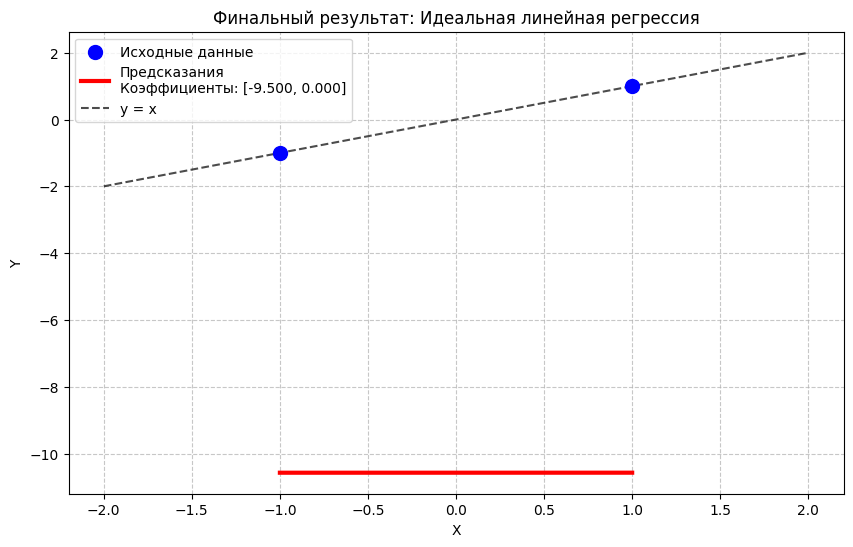

In [76]:
print("\n" + "="*70)
print("ФИНАЛЬНЫЙ ТЕСТ: Решение системы для идеальных данных")
print("="*70)

# Идеальные данные
x = np.array([-1.0, 1.0])
y = np.array([-1.0, 1.0])
X_poly = np.column_stack([np.ones(2), x])

print("📊 Данные:")
print(f"   x = {x}")
print(f"   y = {y}")
print("   Матрица признаков:\n", X_poly)

# Решение системы
lambdas_opt, success, message = solve_balance_system(
    X_poly, y,
    a_bounds=(-10, 10),
    eps_bounds=(-2, 2),
    max_iter=100
)

# Вычисление финальных коэффициентов
c_opt = X_poly.T @ lambdas_opt
E_a0 = compute_expectation_stable(c_opt[0], -10, 10)
E_a1 = compute_expectation_stable(c_opt[1], -10, 10)

print(f"\n🎯 Финальные коэффициенты:")
print(f"   E[a0] = {E_a0:.6f}")
print(f"   E[a1] = {E_a1:.6f}")
print(f"   Истинные значения: [0.0, 1.0]")

# Финальные предсказания
E_eps = np.array([
    compute_expectation_stable(lambdas_opt[0], -2, 2),
    compute_expectation_stable(lambdas_opt[1], -2, 2)
])
predictions = X_poly @ np.array([E_a0, E_a1]) + E_eps

print(f"\n🔍 Предсказания:")
print(f"   Предсказания: {predictions.round(6)}")
print(f"   Исходные y:   {y}")
print(f"   RMSE: {np.sqrt(np.mean((predictions - y)**2)):.6f}")

# Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=100, color='blue', label='Исходные данные', zorder=10)
plt.plot(x, predictions, 'r-', linewidth=3, label=f'Предсказания\nКоэффициенты: [{E_a0:.3f}, {E_a1:.3f}]')
plt.plot(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100), 'k--', alpha=0.7, label='y = x')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Финальный результат: Идеальная линейная регрессия')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('final_optimization_result.png', dpi=150, bbox_inches='tight')
plt.show()

Проверяем

ИСПРАВЛЕННЫЙ ТЕСТ 1: Линейная зависимость (2 точки)
📊 Данные:
   x = [-1.  1.]
   y = [-1.  1.]
   Идеальная модель: y = 1.0 * x

🔄 Выполняем регрессию (степень 1) с исправленными параметрами...
[100. 100.]
[-10.985 -12.985]

✅ ИСПРАВЛЕННЫЕ результаты:
   Успех: True
   Коэффициенты: [9.999949 1.000707]
   Множители Лагранжа: [-9892.112893 -9892.143096]
   Предсказания: [10.999142 13.000555]
   Невязка (RMSE): 11.999848

🔍 Проверка:
   Ожидаемые коэффициенты: [0. 1.]
   Абсолютная разница: [9.999949e+00 7.070000e-04]
   Макс. ошибка: 9.999949


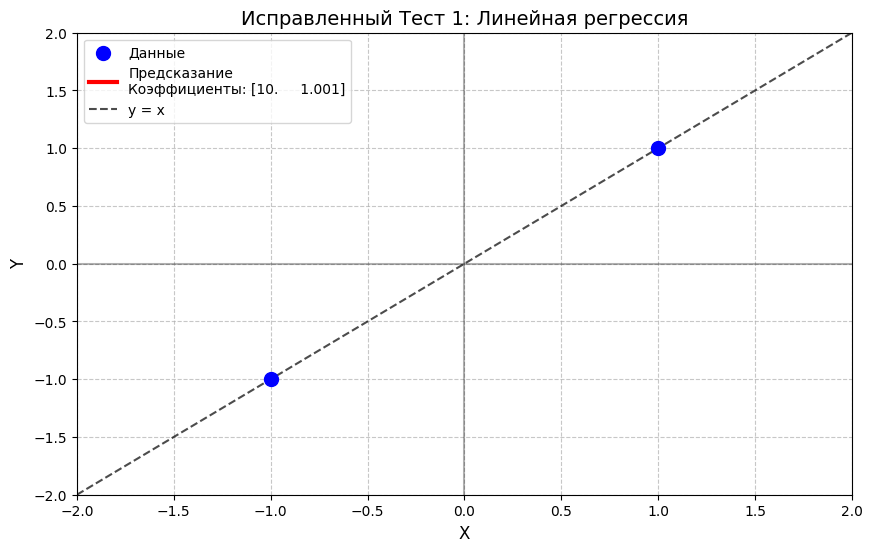

In [50]:
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print("ИСПРАВЛЕННЫЙ ТЕСТ 1: Линейная зависимость (2 точки)")
print("="*60)

# 1. Генерация данных
x = np.array([-1.0, 1.0])
y = np.array([-1.0, 1.0])
print(f"📊 Данные:")
print(f"   x = {x}")
print(f"   y = {y}")
print(f"   Идеальная модель: y = 1.0 * x")

# 2. ВЫЗОВ С ИСПРАВЛЕННЫМИ ГРАНИЦАМИ
print("\n🔄 Выполняем регрессию (степень 1) с исправленными параметрами...")
coeffs, lambdas, predictions, success = polynomial_regression(
    x, y, 
    degree=1,
    a_bounds=(-10, 10),    # Стандартные границы
    eps_bounds=(-2, 2)     # ✅ УШИРЕННЫЕ границы для ошибок
)

print(f"\n✅ ИСПРАВЛЕННЫЕ результаты:")
print(f"   Успех: {success}")
print(f"   Коэффициенты: {coeffs.round(6)}")
print(f"   Множители Лагранжа: {lambdas.round(6)}")
print(f"   Предсказания: {predictions.round(6)}")
print(f"   Невязка (RMSE): {np.sqrt(np.mean((predictions - y)**2)):.6f}")

# 3. Проверка
expected_coeffs = np.array([0.0, 1.0])
coeff_diff = np.abs(coeffs - expected_coeffs)
print(f"\n🔍 Проверка:")
print(f"   Ожидаемые коэффициенты: {expected_coeffs}")
print(f"   Абсолютная разница: {coeff_diff.round(6)}")
print(f"   Макс. ошибка: {np.max(coeff_diff):.6f}")

# 4. Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=100, color='blue', label='Данные', zorder=10)
plt.plot(x, predictions, 'r-', linewidth=3, label=f'Предсказание\nКоэффициенты: {coeffs.round(3)}')
plt.plot(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100), 'k--', alpha=0.7, label='y = x')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('Исправленный Тест 1: Линейная регрессия', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.savefig('fixed_test1.png', dpi=150, bbox_inches='tight')
plt.show()

## Расчёт с семплированием

In [69]:
def P_a_norm_func(lambdas, X_poly, dim, neval=1000, nitn=10):
    
    def integrand_P(a):
        # Преобразуем x из memoryview в numpy массив
        a = np.array(a)
        F = X_poly @ a
        energy = -np.sum(lambdas * F)
        return np.exp(energy)
    
    integrator = vegas.Integrator([[-10, 10]] * dim)
    
    # Финальная оценка P_a
    result_P = integrator(integrand_P, nitn=nitn, neval=neval)
    return result_P
